# Gaussian wave packet dynamics 

Chad Heaps  
April 2018

This notebook includes illustrative examples of the pseudospectral Gaussian wave packet method.

Both the source code and this notebook are a work in progress.  

In [1]:
import os
import time
import copy
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import pygwpd
from pygwpd import sinc_nonadiabatic
from pygwpd import nonadiabatic_model
from pygwpd import single_surface_model as ssm
from pygwpd import potential
from pygwpd import basis_function
from pygwpd.calc_spectrum import calc_spectrum
from pygwpd import sinc_single_surface


In [2]:
mpl.rcParams['animation.writer'] = 'imagemagick'
# #Font specification is somewhat frustrating.  The options from
# #mpl.rcParams.keys() don't match up with possible system fonts.  Instead,
# #you can set the family based on the list of available fonts printed below
# #with the commented out code
mpl.rcParams['font.family'] = 'Times New Roman'

##Set font sizes
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
mpl.rcParams['font.size'] = SMALL_SIZE
mpl.rcParams['axes.titlesize'] = BIGGER_SIZE
mpl.rcParams['axes.labelsize'] = MEDIUM_SIZE
mpl.rcParams['xtick.labelsize'] = SMALL_SIZE
mpl.rcParams['ytick.labelsize'] = SMALL_SIZE
mpl.rcParams['legend.fontsize'] = MEDIUM_SIZE
mpl.rcParams['figure.titlesize'] = BIGGER_SIZE+2
mpl.rcParams['mathtext.fontset'] = 'cm' #Much nicer math formatting


# Animation of morse oscillator dynamics
The first part of this notebook visualizes the time-evolution of a 1-D wave packet in a Morse oscillator

### Specifying model parameters
Set all of the necessary parameters for WF propagation following the paper  https://aip.scitation.org/doi/abs/10.1063/1.4946807.

The parameters have been used in many quantum dynamics papers over the years.

The cell below is effectively an annotated input file if running the script from the command line


In [3]:
morse_pseudo_params = {}

#Potential energy model
morse_pseudo_params['model'] = potential.Morse()

#Basis function and basis set parameters
morse_pseudo_params['mass'] = 1.0              #Mass of system
morse_pseudo_params['x0'] = np.array([9.32])   #Initial coordinate for each dimension
morse_pseudo_params['k0'] = np.array([0.0])    #Initial momentum for each dimension
morse_pseudo_params['basis_function_width'] = np.array([0.5])  #alpha - basis function widht parameter
morse_pseudo_params['basis_set_size'] = 200    #Number of basis functions
morse_pseudo_params['add_cs'] = False #Boolean to make last basis function correspond to the initial state
#Called 'cs' for coherent state

#run parameters
morse_pseudo_params['integrator'] = 'RK4' #Select integrator, RK4 is only current option
morse_pseudo_params['time_step'] = 0.1    #ODE timestep
morse_pseudo_params['prop_time'] =25.0   #Total propagation time
morse_pseudo_params['job_name'] = 'morse_pseudo_ex' 
morse_pseudo_params['tcf_type'] = 2 #whether to evaluate trick where TCF 
#can be calculated at 2*t if initial wave packet has zero initial KE
morse_pseudo_params['wf_renorm'] = True



#Options for saving the wave function at various times
#At the selected time, the basis set is projected onto a grid of evenly spaced points
#Only valid for 1 and 2-dimensional cases
morse_pseudo_params['save_wf_times'] = None #np.array([4.0, 6.0]) #Times at which to calculate the wave function
#Whether you store the calculated WFs in memory
morse_pseudo_params['store_wf'] = True
#Whether they are written to text files
morse_pseudo_params['write_wf'] = False
#A boolean to save all steps.  I added this primarily for animations
morse_pseudo_params['save_all_wf'] = True

#Solution of QM coefficients
#The two options for matrix_type are pseudospectral or galerkin
#only pseudospectral is available for nonadiabatic calculations
morse_pseudo_params['matrix_type'] = 'pseudospectral' #Default

# morse_pseudo_params['solver'] = 'bicg' #The paper uses the lstsq, but I have been testing other methods
morse_pseudo_params['solver'] = 'lstsq'
morse_pseudo_params['svd_threshold'] = 1e-3

#Initialize ODE class
morse_pseudo_ex = ssm.GWPD_SS_Model(**morse_pseudo_params)

#Generates the initial basis set, available as 'init_basis' attribute which is
#a class instance of Basis_function.  'prop_basis' is a copied instance that 
#is modified at each time
#This needs to be called before just about anything else
morse_pseudo_ex.setup_basis()

##This will propagate to prop_time
morse_pseudo_ex.propagate()


## Calculate reference using the sinc pseudospectral method

In [4]:
ref_morse_params = {}
ref_morse_params['model'] = potential.Morse()
ref_morse_params['mass'] = 1.0
ref_morse_params['x0'] = np.array([9.32])
ref_morse_params['k0'] = np.array([0.0]) 
ref_morse_params['wavepacket_width'] = np.array([0.5])
ref_morse_params['grid_lims'] = np.array([[-5., 15.]])
ref_morse_params['grid_spacing'] = 5e-2
ref_morse_params['prop_time'] = 25.0
ref_morse_params['time_step'] = 0.1
ref_morse_params['tcf_type'] = 2
ref_morse_params['save_all_wf'] = True
ref_morse_params['integrator'] = 'exp'
ref_morse_params['lanczos_thresh'] = 1e-6
ref_morse = sinc_single_surface.Sinc_Single_Surface(**ref_morse_params)
print(ref_morse.nbasis)
ref_morse.propagate()

401
Construction of propagator is complete


### Generate animation in Matplotlib

First, we will animate the real and imaginary components of the wave function in addition to the density

In [5]:

nsteps = int((morse_pseudo_ex.prop_time / morse_pseudo_ex.time_step)) + 1
mx = np.linspace(-5,15, 500)
model_y = morse_pseudo_ex.model.calc_V(mx.reshape(-1,1))

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(mx, model_y/8., 'g-', label='Morse')
ref_dens,  = ax.plot([], [], 'k-', label='Reference')
dens,     = ax.plot([], [], 'r+-', label='Density')
psi_real, = ax.plot([], [], 'bo-', label = r'Re($\Psi$)')
psi_imag, = ax.plot([], [], 'cx-', label = r'Im($\Psi$)')
ax.legend()

ax.set_xlabel('x (atomic units)')
ax.set_ylabel(r'$\Psi$')
ax.set_title('Morse Dynamics')
time_label = ax.text(0.25, 0.8, '', transform=ax.transAxes)
plt.xlim(-5,15)
plt.ylim(-1.5,1.5)

def init():
    ref_dens.set_data([], [])
    dens.set_data([],[])    
    psi_real.set_data([],[])
    psi_imag.set_data([],[])
    time_label.set_text('')
    return ref_dens, dens, psi_real, psi_imag, time_label
def animate(num):
    thisx = morse_pseudo_ex.prop_basis.wfs[str(num)][:, 0].real
    thisy = morse_pseudo_ex.prop_basis.wfs[str(num)][:, 1]
    dens.set_data(thisx, np.absolute(thisy)**2)
    ref_dens.set_data(ref_morse.wfs[str(num)][:,0].real, np.absolute(ref_morse.wfs[str(num)][:,-1])**2)
    psi_real.set_data(thisx, thisy.real)
    psi_imag.set_data(thisx, thisy.imag)
    time_label.set_text('t = {:4.2f}'.format(morse_pseudo_ex.time_step*num))
    
    return ref_dens, dens, psi_real, psi_imag, time_label

morse_wf_ani = animation.FuncAnimation(fig, animate, frames=nsteps,
                                   interval=150, blit=False, init_func=init,
                                   repeat=False)
# Writer = animation.writers['imagemagick']
# writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

#line_ani.save('morse.html', writer=writer)
#line_ani.save('morse.gif', dpi=80, writer='imagemagick')
plt.close()



In [6]:
#Uncomment this line to generate animation
# HTML(morse_wf_ani.to_jshtml())

## Time-correlation function (TCF)

The TCF for an arbitrary wave function at time $t$ is calculated by
\begin{equation}
C(t) = \langle \Psi(t=0) | \Psi(t) \rangle
\end{equation}

If the initial wave packet is real, the TCF at $2t$ can be calculated using

\begin{equation}
C(t) = \langle \Psi^*(t/2) | \Psi(t/2) \rangle
\end{equation}

Aside from scattering calculations (which are, of course, important), many dynamics calculations start with zero kinetic energy and therefore real. 

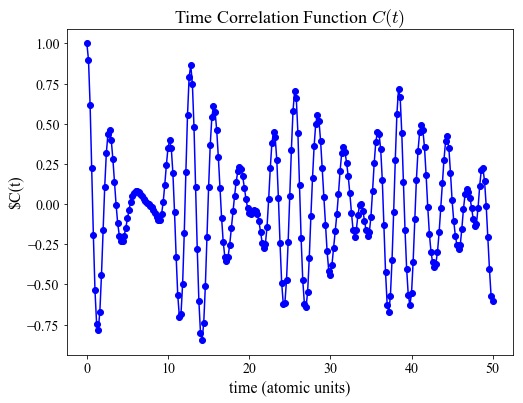

In [7]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

x = morse_pseudo_ex.tcf[:,0].real
y = morse_pseudo_ex.tcf[:,1].real

ax.plot(x,y, 'bo-')

ax.set_title('Time Correlation Function $C(t)$')
ax.set_xlabel('time (atomic units)')
ax.set_ylabel('$C(t)')

plt.show()

## Comparing approximations to the potential energy

Below, I create two additional objects, one uses analytical integrals and the galerkin formatulion, the other uses the bra-ket averaged Taylor expansion (BAT).  The BAT is an $\mathcal{O}(N)$ approximation for the Galerkin integrals. See, for example, https://aip.scitation.org/doi/10.1063/1.4891530

We will instantantiate these two class instances and calculate the wave function data for them.

Consistent with our paper, all three methods capture the qualitative features of the dynamics. However, following repeated reflections, the phase structure of the BAT solution deviates from the exact solution 


In [8]:
#Analytical example
analytical_morse_params = copy.copy(morse_pseudo_params)
analytical_morse_params['job_name'] = 'morse_analytical_ex' 
analytical_morse_params['matrix_type'] = 'galerkin' 
analytical_morse_params['galerkin_approx'] = 'analytical'
morse_analytical_ex = ssm.GWPD_SS_Model(**analytical_morse_params)
morse_analytical_ex.setup_basis()
morse_analytical_ex.propagate()
#BAT example
bat_morse_params = copy.copy(morse_pseudo_params)
bat_morse_params['job_name'] = 'morse_bat_ex' 
bat_morse_params['matrix_type'] = 'galerkin' 
bat_morse_params['galerkin_approx'] = 'bat'
morse_bat_ex = ssm.GWPD_SS_Model(**bat_morse_params)
morse_bat_ex.setup_basis()
morse_bat_ex.propagate()


In [9]:
# nsteps = int((morse_analytical_ex.prop_time / morse_analytical_ex.time_step)) + 1
# for step in range(nsteps):
#     morse_analytical_ex.prop_basis.plot_psi('morse', step, 
#                             write_data = False, 
#                             store_data = True,
#                             xspace = 0.25)
#     morse_analytical_ex.rk4_single_step(step)
    
#     morse_bat_ex.prop_basis.plot_psi('morse', step, 
#                             write_data = False, 
#                             store_data = True,
#                             xspace = 0.25)
#     morse_bat_ex.rk4_single_step(step)

### Animate the densities for all three cases along with reference

In [10]:
nsteps = int((morse_analytical_ex.prop_time / morse_analytical_ex.time_step)) + 1
mx = np.linspace(-5,15, 500)
model_y = morse_analytical_ex.model.calc_V(mx.reshape(-1,1))
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(mx, model_y/15., 'g-', label=None)
ref_dens,        = ax.plot([], [], 'k-', label='Sinc Pseudospectral')
dens_pseudo,     = ax.plot([], [], 'r+-', label='Pseudo-Gaussian')
dens_analytical, = ax.plot([], [], 'b+-', label='Analytical')
dens_bat,        = ax.plot([], [], 'g+-', label='BAT')
ax.legend(loc='lower left')
ax.set_xlabel('x (atomic units)')
ax.set_ylabel(r'$|\Psi|^2$')
ax.set_title('Morse Dynamics Comparison')
time_label = ax.text(0.1, 0.95, '', transform=ax.transAxes)
plt.xlim(-5,15)
plt.ylim(-0.5,0.4)


def init():
    ref_dens.set_data([],[])   
    dens_pseudo.set_data([],[])    
    dens_analytical.set_data([],[])    
    dens_bat.set_data([],[])    
    time_label.set_text('')
    return ref_dens, dens_pseudo, dens_analytical, dens_bat, time_label
def animate(num):
    ref_dens.set_data(ref_morse.wfs[str(num)][:,0].real, np.absolute(ref_morse.wfs[str(num)][:,-1])**2)
    x_pseudo = morse_pseudo_ex.prop_basis.wfs[str(num)][:, 0].real
    y_pseudo = np.abs(morse_pseudo_ex.prop_basis.wfs[str(num)][:, 1])**2
    dens_pseudo.set_data(x_pseudo, y_pseudo) 
    x_analytical = morse_analytical_ex.prop_basis.wfs[str(num)][:, 0].real
    y_analytical = np.abs(morse_analytical_ex.prop_basis.wfs[str(num)][:, 1])**2
    dens_analytical.set_data(x_analytical, y_analytical)
    x_bat = morse_bat_ex.prop_basis.wfs[str(num)][:, 0].real
    y_bat = np.abs(morse_bat_ex.prop_basis.wfs[str(num)][:, 1])**2
    dens_bat.set_data(x_bat, y_bat)

    time_label.set_text('t = {:4.2f}'.format(morse_analytical_ex.time_step*num))    
    return ref_dens, dens_pseudo, dens_analytical, dens_bat, time_label

morse_compare_ani = animation.FuncAnimation(fig, animate, frames=nsteps,
                                   interval=150, blit=False, init_func=init,
                                   repeat=False)
# Writer = animation.writers['imagemagick']
# writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
#line_ani.save('morse.html', writer=writer)
#line_ani.save('morse.gif', dpi=80, writer='imagemagick')
plt.close()
# HTML(line_ani.to_jshtml())

In [11]:
#Uncomment this line to generate animation
# HTML(morse_compare_ani.to_jshtml())

# Henon-Heiles 2-D potential

For $N_d$-dimensions, the Henon-Heiles potential used here and in the paper is

\begin{equation}
V(\mathbf{x}) = \frac{1}{2} \sum_{i=1}^{N_d} x_i^2 + \lambda \sum_{i=1}^{N_d - 1} \left(x_i^2x_{i+1} - \frac{1}{3} x^3_{i+1}\right)
\end{equation}
where we set $\lambda = \sqrt{\frac{1}{80}}$, a parameter from previous papers

In [12]:
input_params = {}
#Potential energy model
input_params['model'] = potential.HH2dMCTDH()

#Basis function and basis set parameters
input_params['mass'] = 1.0              #Mass of system
input_params['x0'] = np.array([2.0, 2.0])   #Initial coordinate for each dimension
input_params['k0'] = np.array([0.0, 0.0])    #Initial momentum for each dimension
input_params['basis_function_width'] = np.array([0.5, 0.5])  #alpha - basis function widht parameter
input_params['basis_set_size'] = 150    #Number of basis functions
input_params['add_cs'] = False #Boolean to make last basis function correspond to the initial state
#Called 'cs' for coherent state

#run parameters
input_params['integrator'] = 'RK4' 
input_params['time_step'] = 0.05   
input_params['prop_time'] = 25.0   
input_params['job_name'] = 'hh2d_ex' 
input_params['tcf_type'] = 2 

input_params['save_wf_times'] = None
input_params['save_all_wf'] = False
input_params['store_wf'] = True
input_params['write_wf'] = False
input_params['wf_grid_space'] = 1.0



#Solution of QM coefficients
input_params['matrix_type'] = 'pseudospectral' 
# input_params['solver'] = 'bicg' 
input_params['solver'] = 'lstsq'
input_params['svd_threshold'] = 1e-4

#Initialize ODE class
hh2d_ex = ssm.GWPD_SS_Model(**input_params)

hh2d_ex.setup_basis()
# hh2d_ex.propagate()

In [13]:

ref_hh2d_params = {}
ref_hh2d_params['model'] = potential.HH2dMCTDH()
ref_hh2d_params['mass'] = 1.0
ref_hh2d_params['ndim'] = 2
ref_hh2d_params['x0'] = np.array([2.0, 2.0])
ref_hh2d_params['k0'] = np.array([0.0, 0.0]) 
ref_hh2d_params['wavepacket_width'] = np.array([0.5, 0.5])
# ref_hh2d_params['grid_lims'] = np.array([[-8., 8.],
#                                          [-8., 8.]])
ref_hh2d_params['grid_lims'] = np.array([[-12., 12.],
                                         [-12., 12.]])

ref_hh2d_params['grid_spacing'] = 0.5
ref_hh2d_params['prop_time'] = 25.0
ref_hh2d_params['time_step'] = 0.05
ref_hh2d_params['tcf_type'] = 2
ref_hh2d_params['save_all_wf'] = True
ref_hh2d_params['integrator'] = 'exp'
ref_hh2d_params['lanczos_thresh'] = 1e-12
ref_hh2d_params['lanczos_dim'] = 10
ref_hh2d = sinc_single_surface.Sinc_Single_Surface(**ref_hh2d_params)
print(ref_hh2d.nbasis)
ref_hh2d.propagate()

2401
Construction of Hamiltonian complete
Construction of propagator is complete


In [14]:
nsteps = int((hh2d_ex.prop_time / hh2d_ex.time_step)) + 1
print(nsteps)
plot_psi_t = []
rk4_t = []
for step in range(nsteps):
    #Propagate a single RK4 step
    t_1 = time.time()
    hh2d_ex.prop_basis.plot_psi('hh2d', step, 
                            write_data = False, 
                            store_data = True,
                            xspace = 0.4,
                            x_lims = np.array([[-10., 10.],[-10,10]]))
    #print('Time to evaluate basis ', time.time() - t_1)
    plot_psi_t.append(time.time() - t_1)
    t_2 = time.time()
    hh2d_ex.rk4_single_step(step)
    rk4_t.append(time.time() - t_2)
plot_psi_t = np.array(plot_psi_t)
rk4_t = np.array(rk4_t)
print('Mean time to calculate wave function on grid {:6.5f} sec'.format(np.mean(plot_psi_t)))
print('Mean time to calculate RK4 step {:6.5f} sec'.format(np.mean(rk4_t)))

501
Mean time to calculate wave function on grid 0.05581 sec
Mean time to calculate RK4 step 0.08923 sec


In [15]:
Writer = animation.writers['imagemagick']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

fig, ax = plt.subplots(figsize=(8,6))
xx = hh2d_ex.prop_basis.wfs['0'][:,0].real
yy = hh2d_ex.prop_basis.wfs['0'][:,1].real
nx = np.unique(xx).size
ny = np.unique(yy).size
zzz = (np.absolute(hh2d_ex.prop_basis.wfs['0'][:,2])**2).reshape(ny,nx)
xx = xx.reshape(ny,nx)
yy = yy.reshape(ny,nx)
dens = plt.pcolormesh(xx, yy, zzz, shading='gouraud')
ax.set_xlabel('x (atomic units)')
ax.set_xlabel('y (atomic units)')
ax.set_title('Henon-Heiles Dynamics')
time_label = ax.text(0.05, 1.005, '', transform=ax.transAxes)

ax.set_aspect('equal')

def init():
    dens.set_array(np.array([]))    
    time_label.set_text('')
    return dens, time_label

def animate(num):
    
    zz = hh2d_ex.prop_basis.wfs[str(num)][:,2]
    dens.set_array((np.absolute(zz)**2))
    time_label.set_text('t = {:4.2f}'.format(hh2d_ex.time_step*num))
    
    return dens, time_label

hh2d_ani = animation.FuncAnimation(fig, animate, frames=nsteps,
                                   interval=100, blit=False, init_func=init,
                                   repeat=False)
#line_ani.save('hh2d.html', writer=writer)
#line_ani.save('hh2d.gif', dpi=80, writer='imagemagick')

# To save the animation, use the command: line_ani.save('lines.mp4')
plt.close()


In [16]:
#Uncomment this line to generate animation
# HTML(hh2d_ani.to_jshtml())

## 2-D Henon-Heiles TCF

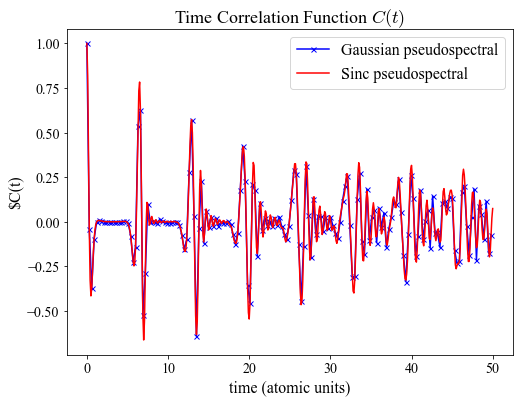

In [17]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

x = hh2d_ex.tcf[:,0].real
y = hh2d_ex.tcf[:,1].real

x_ref = ref_hh2d.tcf[:,0].real
y_ref = ref_hh2d.tcf[:,1].real

# ax.plot(x,y, 'b-')
ax.plot(x[::3],y[::3], 'bx-', markersize=5,  label = 'Gaussian pseudospectral' )
ax.plot(x_ref,y_ref, 'r-', label = 'Sinc pseudospectral')
ax.legend()
ax.set_title('Time Correlation Function $C(t)$')
ax.set_xlabel('time (atomic units)')
ax.set_ylabel('$C(t)')

plt.show()

## 6-D Henon-Heiles Spectrum

In [18]:
input_params = {}
#Potential energy model
input_params['model'] = potential.HH6d()

#Basis function and basis set parameters
input_params['mass'] = 1.0              #Mass of system
input_params['x0'] = 2.0*np.ones([6])   #Initial coordinate for each dimension
input_params['k0'] = np.zeros([6])    #Initial momentum for each dimension
input_params['basis_function_width'] = 0.5*np.ones([6])
input_params['basis_set_size'] = 150    #Number of basis functions
input_params['basis_compression'] = 0.3
input_params['add_cs'] = True #Boolean to make last basis function correspond to the initial state
#Called 'cs' for coherent state

#run parameters
input_params['integrator'] = 'RK4' #Select integrator, RK4 is only current option
input_params['time_step'] = 0.1    #ODE timestep
input_params['prop_time'] = 50.0   #Total propagation time
input_params['save_wf_times'] = None #np.array([4.0, 6.0]) #Times at which to write wave function to text file
input_params['job_name'] = 'hh6d_ex' 
input_params['tcf_type'] = 2 #whether to evaluate trick where TCF 
#can be calculated at 2*t if initial wave packet has zero initial KE
input_params['store_wf'] = False #whether to store WF in memory for save_wf_times

#Solution of QM coefficients
input_params['matrix_type'] = 'pseudospectral' #Default, uses the method in the Heaps+Mazziotti paper
# input_params['solver'] = 'bicg' #The paper uses the lstsq, but been testing other methods
input_params['solver'] = 'lstsq'
input_params['svd_threshold'] = 5e-4

#Initialize ODE class
hh6d_ex = ssm.GWPD_SS_Model(**input_params)

hh6d_ex.setup_basis()
hh6d_ex.propagate()


In [19]:
calc_spectrum(hh6d_ex)

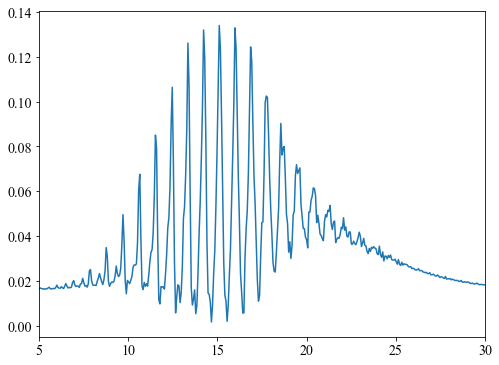

In [20]:
x1 = hh6d_ex.spectrum['freq_100'].real
y1 = hh6d_ex.spectrum['data_100'].real

fig, ax = plt.subplots(1,1,figsize=(8,6))

ax.plot(x1,y1)

#If you download the Henon-Heiles data from http://www.pci.uni-heidelberg.de/tc/usr/mctdh/benchmarks/
#you can plot the MCTDH results to compare.  The current parameters d an okay
#job of reproducing the MCTDH spectrum, but were selected for efficiency
# mctdh_hh6d = np.loadtxt('henon-heiles/6d/spectrum.pl', skiprows=1)
# x2 = mctdh_hh6d[:,0]
# y2 = mctdh_hh6d[:,1]
# ax.plot(x2, y2)
ax.set_xlim(5,30)
plt.show()

# Nonadiabatic Dynamics

Here are a couple of examples using the pseudospectral Gaussian method for nonadiabatic dynamics.

## Tully Model 1

In [21]:
params_tully1 = {}

#Potential energy model
params_tully1['model'] = potential.Tully1()

#Basis function and basis set parameters
params_tully1['mass'] = 2000.0      
params_tully1['x0'] = np.array([-2.5]) 
params_tully1['k0'] = np.array([20.0]) 
params_tully1['basis_function_width'] = np.array([1.0])  
params_tully1['basis_set_size'] = 40 
params_tully1['add_cs'] = False

#Nonadiabatic options
params_tully1['basis_velocity'] = 'ehrenfest'
params_tully1['electronic_rep'] = 'adiabatic'
#Initial state (indexed to 0)
params_tully1['init_surface'] = 0

#run parameters
params_tully1['integrator'] = 'RK4'
params_tully1['time_step'] = 4.0   
params_tully1['prop_time'] = 700.0  
params_tully1['save_wf_times'] = None
params_tully1['job_name'] = 'tully1_ex'
params_tully1['tcf_type'] = 1
params_tully1['store_wf'] = True 
params_tully1['write_wf'] = False 
params_tully1['wf_renorm'] = True
params_tully1['save_all_wf'] = True #Saves wf at every step for animation
#Solution of QM coefficients
params_tully1['matrix_type'] = 'pseudospectral'
# params_tully1['solver'] = 'bicg' 
params_tully1['solver'] = 'lstsq'
params_tully1['svd_threshold'] = 1e-4

#Initialize ODE class
tully1_ex = pygwpd.nonadiabatic_model.GWPD_Nonadiabatic_Model(**params_tully1)

tully1_ex.setup_basis()
tully1_ex.propagate()

    

In [22]:
ref_tully1_params = {}
ref_tully1_params['model'] = potential.Tully1()
ref_tully1_params['mass'] = 2000.0
ref_tully1_params['x0'] = np.array([-2.5])
ref_tully1_params['k0'] = np.array([20.0]) 
ref_tully1_params['wavepacket_width'] = np.array([1.0])
ref_tully1_params['grid_lims'] = np.array([[-10., 25.]])
ref_tully1_params['n_surface'] = 2
ref_tully1_params['electronic_representation'] = 'adiabatic'
ref_tully1_params['init_surface'] = 0
ref_tully1_params['grid_spacing'] = 0.091
ref_tully1_params['prop_time'] = 700.0
ref_tully1_params['time_step'] = 4.0
ref_tully1_params['tcf_type'] = 1
ref_tully1_params['save_all_wf'] = True
ref_tully1_params['integrator'] = 'exp'
ref_tully1 = sinc_nonadiabatic.Sinc_Nonadiabatic(**ref_tully1_params)
print(ref_tully1.nbasis)
ref_tully1.propagate()

385


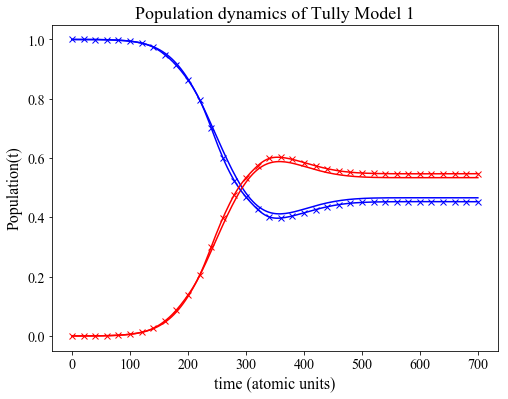

In [23]:
ref_x = ref_tully1.pops[:,0]
ref_y1 = ref_tully1.pops[:,1]
ref_y2 = ref_tully1.pops[:,2]

gauss_x =  tully1_ex.pops[:,0]
gauss_y1 = tully1_ex.pops[:,1]
gauss_y2 = tully1_ex.pops[:,2]

fig, ax = plt.subplots(1,1,figsize=(8,6))


ax.plot(ref_x, ref_y1, 'b-')
ax.plot(ref_x, ref_y2, 'r-')
ax.plot(gauss_x, gauss_y1, 'bx-', markevery=5)
ax.plot(gauss_x, gauss_y2, 'rx-',  markevery=5)
ax.set_title('Population dynamics of Tully Model 1')
ax.set_xlabel('time (atomic units)')
ax.set_ylabel('Population(t)')
# ax.set_xlim(0,250)

plt.show()

In [35]:
nsteps =  tully1_ex.nsteps
gauss_psi = tully1_ex.prop_basis.wfs
ref_psi = ref_tully1.wfs

mx = np.linspace(-10,15, 500)
V, V1 = tully1_ex.model.calc_V(mx.reshape(-1,1))
# model_y = tully1_ex.model.calc_V(mx.reshape(-1,1))
fig, ax = plt.subplots(figsize=(8,6))
#ax.plot(mx, V[:,0,0], 'g-', label=None)
#ax.plot(mx, V[:,1,1], 'b-', label=None)
ax.plot(mx, 100*V[:,0,1], 'g-', label='100 x $V_c$')

gaussA, = ax.plot([], [], 'bo', label= 'Gauss A')
gaussB, = ax.plot([], [], 'ro', label= 'Gauss B')
refA,   = ax.plot([], [], 'b-', label= 'Ref A')# linesize=.5)
refB,   = ax.plot([], [], 'r-', label= 'Ref B')# linesize=.5)
ax.set_xlabel('x (atomic units)')
ax.set_ylabel('$|\Psi(x)|^2$')
ax.legend()
time_label = ax.text(0.01, 0.95, '', transform=ax.transAxes)
plt.xlim(-5,10)
plt.ylim(0, 0.8)
 
def init():
    gaussA.set_data([], [])
    gaussB.set_data([], [])
    refA.set_data([], [])
    refB.set_data([], [])
    time_label.set_text('')
    return gaussA, gaussB, refA, refB, time_label
def animate(num):
    xg = gauss_psi[str(num)][:,0].real
    tg = np.abs(gauss_psi[str(num)][:,1:])**2
    rx = ref_psi[str(num)][:,0].real
    ry = np.abs(ref_psi[str(num)][:,1:])**2
    gaussA.set_data(xg, tg[:,0])
    gaussB.set_data(xg, tg[:,1])
    refA.set_data(rx, ry[:,0])
    refB.set_data(rx, ry[:,1])

    time_label.set_text('t = {:4.2f}'.format(tully1_ex.time_step*num))    
    return gaussA, gaussB, refA, refB, time_label

tully_wp_ani = animation.FuncAnimation(fig, animate, frames=nsteps,
                                   interval=200, blit=True, init_func=init,
                                   repeat=False)
# Writer = animation.writers['imagemagick']
# writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
#line_ani.save('morse.html', writer=writer)
#line_ani.save('morse.gif', dpi=80, writer='imagemagick')
plt.close()

In [37]:
# #Uncomment this line to generate animation
# HTML(tully_wp_ani.to_jshtml())

## Nonadiabatic coupled Morse potentials

The pseudospectral Gaussian calculation should run in under 10 minutes, but is certainly the most intensive computation in the notebook.

In [32]:
morse_nonadiabatic_params = {}

#Potential energy model
morse_nonadiabatic_params['model'] = potential.Morse_two_surf()

#Basis function and basis set parameters
morse_nonadiabatic_params['mass'] = 2000.0   
morse_nonadiabatic_params['x0'] = np.array([4.0])   
morse_nonadiabatic_params['k0'] = np.array([0.0])    
morse_nonadiabatic_params['basis_function_width'] = np.array([0.5])  
morse_nonadiabatic_params['basis_set_size'] = 250
morse_nonadiabatic_params['basis_compression'] = 0.7
morse_nonadiabatic_params['wf_renorm'] = True
morse_nonadiabatic_params['add_cs'] = True

#Nonadiabatic options
morse_nonadiabatic_params['basis_velocity'] = 'ehrenfest'
morse_nonadiabatic_params['electronic_rep'] = 'diabatic'
#initial state 0-indexed
morse_nonadiabatic_params['init_surface'] = 0

#run parameters
morse_nonadiabatic_params['integrator'] = 'RK4' 
morse_nonadiabatic_params['time_step'] = 5.0    
morse_nonadiabatic_params['prop_time'] = 10000.0 
morse_nonadiabatic_params['save_wf_times'] = None 
morse_nonadiabatic_params['job_name'] = 'morse_nonadiabatic_ex'
morse_nonadiabatic_params['tcf_type'] = 2 
morse_nonadiabatic_params['store_wf'] = True
morse_nonadiabatic_params['write_wf'] = False
morse_nonadiabatic_params['store_all_wf'] = False
morse_nonadiabatic_params['wf_renorm'] = True

#Solution of QM coefficients
morse_nonadiabatic_params['matrix_type'] = 'pseudospectral' 
morse_nonadiabatic_params['solver'] = 'lstsq'
morse_nonadiabatic_params['svd_threshold'] = 5e-3

#Initialize ODE class
morse_nonadiabatic_ex = nonadiabatic_model.GWPD_Nonadiabatic_Model(**morse_nonadiabatic_params)

morse_nonadiabatic_ex.setup_basis()
morse_nonadiabatic_ex.propagate()


In [30]:
ref_morse_nonadiabatic_params = {}
ref_morse_nonadiabatic_params['model'] = potential.Morse_two_surf()
ref_morse_nonadiabatic_params['mass'] = 2000.0
ref_morse_nonadiabatic_params['x0'] = np.array([4.0])
ref_morse_nonadiabatic_params['k0'] = np.array([0.0]) 
ref_morse_nonadiabatic_params['wavepacket_width'] = np.array([0.5])
ref_morse_nonadiabatic_params['grid_lims'] = np.array([[-10., 25.]])
ref_morse_nonadiabatic_params['n_surface'] = 2
ref_morse_nonadiabatic_params['electronic_representation'] = 'diabatic'
ref_morse_nonadiabatic_params['init_surface'] = 0
ref_morse_nonadiabatic_params['grid_spacing'] = 8e-2
ref_morse_nonadiabatic_params['prop_time'] = 10000.0
ref_morse_nonadiabatic_params['time_step'] = 10.0
ref_morse_nonadiabatic_params['tcf_type'] = 1
ref_morse_nonadiabatic_params['save_all_wf'] = False
ref_morse_nonadiabatic_params['integrator'] = 'exp'
ref_morse_nonadiabatic_params['lanczos_thresh'] = 1e-6
ref_morse_nonadiabatic = sinc_nonadiabatic.Sinc_Nonadiabatic(**ref_morse_nonadiabatic_params)
print(ref_morse_nonadiabatic.nbasis)
ref_morse_nonadiabatic.propagate()


438


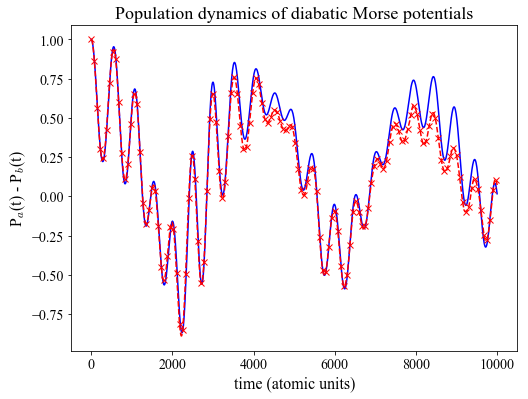

In [34]:
ref_x = ref_morse_nonadiabatic.pops[:,0]
ref_y1 = ref_morse_nonadiabatic.pops[:,1]
ref_y2 = ref_morse_nonadiabatic.pops[:,2]

gauss_x =  morse_nonadiabatic_ex.pops[:,0]
gauss_y1 = morse_nonadiabatic_ex.pops[:,1]
gauss_y2 = morse_nonadiabatic_ex.pops[:,2]

fig, ax = plt.subplots(1,1,figsize=(8,6))


ax.plot(ref_x, ref_y1 - ref_y2, 'b-', label = 'Sinc Pseudospectral')
# ax.plot(ref_x, ref_y2, 'r-')
ax.plot(gauss_x, gauss_y1 - gauss_y2, 'rx--', markevery=15)
# ax.plot(gauss_x, gauss_y2, 'rx--',  markevery=15)
ax.set_title('Population dynamics of diabatic Morse potentials')
ax.set_xlabel('time (atomic units)')
ax.set_ylabel('P$_a$(t) - P$_b$(t)')
# ax.set_xlim(0,250)

plt.show()

In [ ]:
# ref_eckart_params = {}
# ref_eckart_params['model'] = potential.Eckart()
# ref_eckart_params['mass'] = 30.0
# ref_eckart_params['x0'] = np.array([-0.7])
# ref_eckart_params['k0'] = np.array([np.sqrt(50*60.)]) 
# ref_eckart_params['wavepacket_width'] = np.array([np.pi*30.0])
# ref_eckart_params['grid_lims'] = np.array([[-5., 5.]])
# ref_eckart_params['grid_spacing'] = 2e-2
# ref_eckart_params['prop_time'] = 1.5
# ref_eckart_params['time_step'] = 0.001
# ref_eckart_params['tcf_type'] = 1
# ref_eckart_params['save_all_wf'] = True
# ref_eckart_params['integrator'] = 'exp'
# ref_eckart_params['lanczos_thresh'] = 1e-6
# ref_eckart = sinc_single_surface.Sinc_Single_Surface(**ref_eckart_params)
# print(ref_eckart.nbasis)
# ref_eckart.propagate()